In [19]:
import flopy as fp
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.size']=12
import pandas as pd
import os
import sys

## Ce notebook vise à fournir un setup relativement simple d'une interface PEST avec PyEmu de points pilotes sur un modèle basique

PyEmu est une interface python permettant de créer des fichiers PEST et de les manipuler plus facilement qu'avec un éditeur de texte :). Cependant il a ses limites et pas mal de ses fonctions sont des prototypes dont celle qui va être utilisée ici (PstFrom) et **nécessite une installation spécifique** (voir github de PyEmu)

#### Le principe de PsTFrom est de généraliser la création de fichiers PEST sur la base de n'importe quel modèle indépendant. Il fonctionne par utilisation de multiplicateur et ne modifie donc pas directement les paramètres. Il est nécessaire pour cela que les paramètres à modifier, ainsi que les observations soient dans des fichiers à part (et non directement les fichiers du modèle, donc par exemple des fichiers .txt).

In [20]:
workspace = "workspace"
model_name = "test_pst"
exe_name="mf6.exe"

nrow = 100
ncol = 100
delc = 1
delr = 1

#### Tout d'abord créer une fonction pour faire tourner un modèle simple

La partie des observations (OBS) est importante car elle va permettre de fournir un fichier de sortie (heads.csv) pour les observations de PEST. Ici les observations sont réparties homogènement tous les 7 cellules.

In [21]:
def model_run(k):
    
    # spatial param
    nlay = 1

    top = 10
    botm = 0

    # packages
    sim = fp.mf6.MFSimulation(sim_name=model_name, version='mf6', exe_name=exe_name, 
                                 sim_ws=workspace)
    tdis = fp.mf6.ModflowTdis(sim, pname='tdis', time_units='SECONDS', 
                                 nper=1, perioddata=[(1.0, 1, 1.0)])
    gwf = fp.mf6.ModflowGwf(sim, modelname=model_name,
                               model_nam_file='{}.nam'.format(model_name))
    dis = fp.mf6.ModflowGwfdis(gwf, nlay=nlay, nrow=nrow, ncol=ncol,
                                  delr=delr, delc=delc,top=top, botm=botm)
    ims  = fp.mf6.ModflowIms(sim, print_option='SUMMARY', complexity="simple")
    ic   = fp.mf6.ModflowGwfic(gwf,strt=botm+1)

    oc   = fp.mf6.ModflowGwfoc(gwf,budget_filerecord='{}.cbc'.format(model_name),
                                head_filerecord='{}.hds'.format(model_name),
                                saverecord=[('HEAD', 'LAST'),
                                            ('BUDGET', 'LAST')],
                                printrecord=[('HEAD', 'ALL')])
    

    npf  = fp.mf6.ModflowGwfnpf(gwf, icelltype=0, k=k,save_flows=True)
    rch = fp.mf6.ModflowGwfrcha(gwf,recharge=1/86400/365,save_flows=True)
    
    #bc
    chd = []
    for irow in range(nrow):
        chd.append(((0,irow,0),10))
        chd.append(((0,irow,ncol-1),0))
    chd = fp.mf6.ModflowGwfchd(gwf,pname="chd",filename="bc.chd",maxbound=len(chd),stress_period_data=chd,save_flows=True)
    
    
    #OBS
    lst_pts = []
    for irow in range(1,nrow-1,7):
        for icol in range(1,ncol-1,7):
            lst_pts.append((0,irow,icol))
            
    obs_lst1=[]
    for pts in lst_pts:
        obs_lst1.append(("0_{}_{}".format(pts[1],pts[2]),"HEAD",pts))

    obs_recarray = {('heads.csv'):obs_lst1}
    obs_package = fp.mf6.ModflowUtlobs(gwf, pname='head_obs', filename='{}.obs'.format(model_name), 
                                          digits=10, print_input=True,
                                          continuous=obs_recarray)
    
    
    sim.write_simulation(silent=True)
    sim.run_simulation()

#### On rajoute de l'hétéro, 3 gaussiennes

In [22]:
def gauss(A,sig,x,y,x0=0,y0=0):
    g = A**(-((((x-x0)**2)/(2*sig**2))+((y-y0)**2)/(2*sig**2)))
    return g

FloPy is using the following  executable to run the model: .\mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.0.4 03/13/2019

   MODFLOW 6 compiled Mar 21 2019 15:37:31 with IFORT compiler (ver. 19.0.0)

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neither the USGS nor the U.S. 
Government shall be held liable for any damages resulting from its 
authorized or unauthorized use. Also refer to the USGS Water 
Resources Software Use

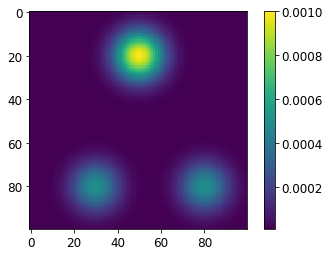

In [23]:
x = np.arange(0,ncol,delr)
y = np.arange(0,nrow,delc)
X,Y = np.meshgrid(x,y)

k = 1e-3*gauss(5,10,X,Y,x0=50,y0=20)
k += 5e-4*gauss(5,10,X,Y,x0=30,y0=80)
k += 5e-4*gauss(5,10,X,Y,x0=80,y0=80)
k[k<1e-5]=1e-5
plt.imshow(k)
plt.colorbar()

filnm = "k.txt"
np.savetxt(os.path.join(workspace,filnm),k)
model_run(filnm)

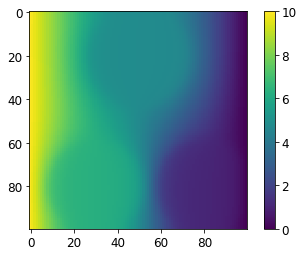

In [24]:
plt.imshow(fp.utils.HeadFile("workspace/{}.hds".format(model_name)).get_data((0,0))[0])
plt.colorbar()

### On a notre modèle FloPy sous Modflow 6, on peut commencer à essayer de setup PEST

D'abord importer pyemu

In [25]:
import pyemu

On load ensuite le modèle précèdemment créé et on récupère les infos spatiales (pour les pilots points)

In [26]:
sim = fp.mf6.MFSimulation.load(sim_ws=workspace)
m = sim.get_model(model_name)
sr = pyemu.helpers.SpatialReference.from_namfile(
        os.path.join(workspace, "{}.nam".format(model_name)),
        delr=m.dis.delr.array, delc=m.dis.delc.array)

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package ic...
    loading package oc...
    loading package npf...
    loading package rch...
    loading package chd...
    loading package obs...
  loading ims package test_pst...
   could not remove start_datetime


On peut ensuite créer un objet PstFrom qui contiendra toutes les infos (paramètres, observations,...). On doit lui fournir un nom de dossier afin d'y créer les fichiers PEST, ici "template". PstFrom nécessite d'avoir installé la version prototype de PyEmu (31.07.2020)

In [27]:
# empty pst from object
template_ws = "template"
pf = pyemu.prototypes.PstFrom(original_d=workspace, new_d=template_ws,
                 remove_existing=True,
                 longnames=True, spatial_reference=sr,
                 zero_based=False)

2020-07-31 14:02:16.821840 starting: opening PstFrom.log for logging
2020-07-31 14:02:16.821840 starting PstFrom process
2020-07-31 14:02:16.831915 starting: setting up dirs
2020-07-31 14:02:16.831915 starting: removing existing new_d 'template'
2020-07-31 14:02:17.262018 finished: removing existing new_d 'template' took: 0:00:00.430103
2020-07-31 14:02:17.262529 starting: copying original_d 'workspace' to new_d 'template'
2020-07-31 14:02:17.641814 finished: copying original_d 'workspace' to new_d 'template' took: 0:00:00.379285
2020-07-31 14:02:17.651969 finished: setting up dirs took: 0:00:00.820054


#### On peut maintenant ajouter des observations à partir du fichier heads.csv qui a été créé juste avant

- obsgp définit le nom du groupe de l'observation,
- prefix le terme qui sera mis devant le nom de l'observation dans le fichier pst,
- index_cols indique quelle colonne est la colonne d'indice pour ne pas la prendre en compte,
- use_cols montre quelles colonnes prendre en compte

Le défaut de cette méthode c'est qu'elle va générer un fichier .ins (fichier d'instruction pour pest afin de lire les outputs) qui sera faux. Il sera alors nécessaire de le modifier manuellement plus tard...

In [28]:
#add observation
df = pd.read_csv(os.path.join(template_ws,"heads.csv"),index_col=0)

hds_df = pf.add_observations("heads.csv",insfile="heads.csv.ins",index_cols="time",
                use_cols=list(df.columns.values),prefix="hds",obsgp=False)

case = "pest_test"
pf.build_pst("{}.pst".format(case))

2020-07-31 14:02:17.681683 starting: adding observations from tabular output file
2020-07-31 14:02:17.681683 starting: reading list template\heads.csv
2020-07-31 14:02:17.692069 finished: reading list template\heads.csv took: 0:00:00.010386
2020-07-31 14:02:17.692069 starting: building insfile for tabular output file heads.csv
2020-07-31 14:02:17.721702 finished: building insfile for tabular output file heads.csv took: 0:00:00.029633
2020-07-31 14:02:17.721702 starting: adding observation from instruction file 'template\heads.csv.ins'
2020-07-31 14:02:17.751727 finished: adding observation from instruction file 'template\heads.csv.ins' took: 0:00:00.030025
2020-07-31 14:02:17.751727 finished: adding observations from tabular output file took: 0:00:00.070044
noptmax:30, npar_adj:0, nnz_obs:196


### Passons aux paramètres

Comme nous avons des points pilotes, il est nécessaire de leur fournir un variogramme pour le krigeage des points, pyemu propose des fonctions pour le faire

spatial variogram


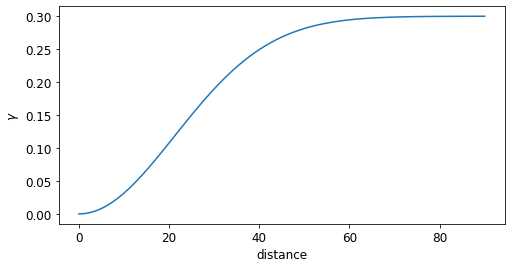

In [29]:
v = pyemu.geostats.GauVario(contribution=0.3,a=30)
grid_gs = pyemu.geostats.GeoStruct(variograms=v, transform='log')

fig = plt.figure(figsize=(8,4))
grid_gs.plot()
print("spatial variogram")

#### On peut alors créer nos pilot points. Avant toute chose on va mettre un champ homogène de k comme valeur initiale et l'enregistrer en fichier txt

In [30]:
# set an homogeneous k array (as initial value)
k = 1e-4*np.ones([nrow,ncol])
filnm = "k.txt"
np.savetxt(os.path.join(template_ws,filnm),k)

#### Afin d'ajouter des paramètres on utilise la méthode .add_parameters de la manière suivante

- upper et lower bound définissent les limites min/max des multiplicateurs des pp
- ult ubound et ult_lbound empêchent les valeurs de k d'aller au dessus/dessous de ces valeurs

In [31]:
pf.add_parameters(filenames="k.txt",par_type="pilotpoint",pp_space=12,
                   par_name_base="kp",pargp="hp",
                   upper_bound=10.,lower_bound=0.1,ult_ubound=1e-3,ult_lbound=1e-5,geostruct=grid_gs)

2020-07-31 14:02:18.191765 starting: adding pilotpoint type multiplier style parameters for file(s) ['k.txt']
2020-07-31 14:02:18.191765 starting: loading array template\k.txt
2020-07-31 14:02:18.231744 finished: loading array template\k.txt took: 0:00:00.039979
2020-07-31 14:02:18.231744 loaded array 'k.txt' of shape (100, 100)
2020-07-31 14:02:18.281619 starting: writing array-based template file 'kp_inst0_pilotpoint.csv.tpl'
2020-07-31 14:02:18.281619 starting: setting up pilot point parameters
2020-07-31 14:02:18.281619 No spatial reference (containing cell spacing) passed.
2020-07-31 14:02:18.281619 OK - using spatial reference in parent object.
ibound not passed, using array of ones
2020-07-31 14:02:18.631716 64 pilot point parameters created
2020-07-31 14:02:18.631716 pilot point 'pargp':kp_inst:0
2020-07-31 14:02:18.641843 finished: setting up pilot point parameters took: 0:00:00.360224
2020-07-31 14:02:18.651736 starting: calculating factors for pargp=kp_inst:0
2020-07-31 14:0

#### A ce stade pyemu a déjà créer pas mal de choses (fichiers tpl, ins) ainsi qu'un forward run qui est un script python pour indiquer à PEST comme lancer le modèle et d'appliquer les multiplicateurs. Il faut cependant encore lui indiquer de faire tourner modflow 6 grâce à la commande : 

In [32]:
# add run model command
pf.mod_sys_cmds.append("..\mf6")
pf.build_pst("{}.pst".format(case))

noptmax:30, npar_adj:64, nnz_obs:196
2020-07-31 14:03:08.861792 forward_run line:pyemu.os_utils.run(r'..\mf6')



pf.build_pst va ici créer le fichier de controle pst qui est le fichier principal de PEST

ET comme dit précèdemment il est nécessaire de réécrire le fichier ins car il est faux (nous avons un csv file et donc les séparateurs sont des , et non des espaces comme mis par pyemu).
Pour ce faire j'ai écrit ce code ci-dessous qui marche bien si le problème n'a qu'un seul temps (plusieurs stress priods exclus)

In [33]:
#Rewrite ins file because Pyemu isn't smart enough

file = "template/heads.csv.ins"
fileout = "template/heads2.csv.ins"
with open(file) as f:
    with open(fileout,"w") as fout:
        for i,line in enumerate(f):
            if i < 2:
                fout.write(line)
            if i > 1:
                for o,split in enumerate(line.split("w")):
                    if o == 1:
                        fout.write("~,~")
                    fout.write(split)
                        
from shutil import copyfile
copyfile(fileout, file) # copy 
os.remove(fileout) # delete tmp file

Tout est fini, il ne reste plus qu'à créer la matrice de covariance pour les analyses d'incertitudes

noptmax:30, npar_adj:64, nnz_obs:196
2020-07-31 14:03:09.191953 WARNING: sys_cmd 'pyemu.os_utils.run(r'..\mf6')
' already in sys cmds, skipping...
2020-07-31 14:03:09.201707 starting: building prior covariance matrix
2020-07-31 14:03:09.221685 saving prior covariance matrix to file template\pest_test.prior.cov
2020-07-31 14:03:09.241761 finished: building prior covariance matrix took: 0:00:00.040054


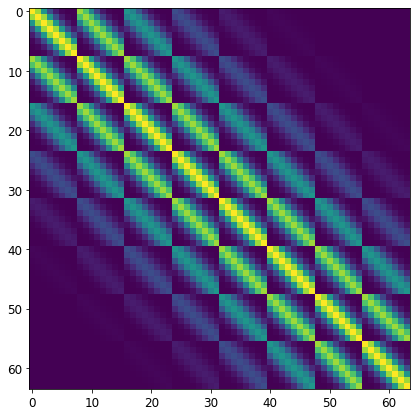

In [34]:
pst = pf.build_pst("{}.pst".format(case))
cov = pf.build_prior()
x = cov.x.copy()
x[x==0.0] = np.NaN
fig,ax = plt.subplots(1,1,figsize=(7,7))
g = ax.imshow(x)

## On est bon ! 
#### On peut alors commencer par calculer la jacobienne en fixant noptmax (nombre d'itérations max de PEST) à -1

In [35]:
t_d = "template"
m_d = "master_glm"

pst.control_data.noptmax = -1 # FOR JACOBIAN
pst.write(os.path.join(t_d,"{}.pst".format(case)))

noptmax:-1, npar_adj:64, nnz_obs:196


In [36]:
# calculate
n = 5 #select number of workers
pyemu.os_utils.start_workers(t_d,"../pestpp-glm.exe","{}.pst".format(case),num_workers=n,worker_root=".",master_dir=m_d)

Voilà ! La suite de l'inversion se passe dans le notebook "inv" :)